<a href="https://colab.research.google.com/github/bozorgpanah/WASP-Software-Engineering-Project/blob/main/Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.7/dist-packages (2.4.1)
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-rbn0gl1m
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-rbn0gl1m
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.067b315b6bfa13cf6f6d42d4c9fdecc7fa1502c04_-cp37-none-any.whl size=147327 sha256=5af82c12d2b5b4ebe1f67dc75623571a18906da089376c8f8f9c699b961ce4cd
  Stored in directory: /tmp/pip-ephem-wheel-cache-yd5a5clu/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs
2.4.1
Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_72 (Dense)             (None, 64)                640       
_________________________________________________________________
dense_73 (Dense)             (None, 64)                4160      
______

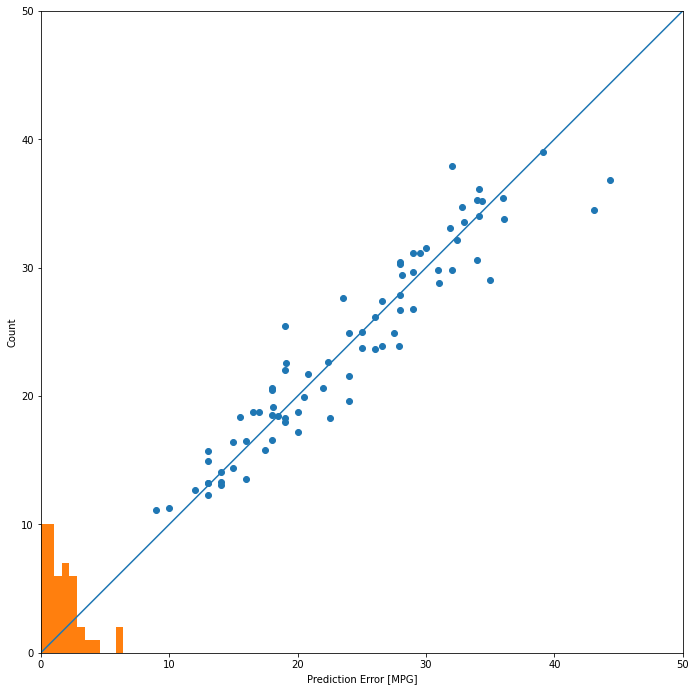

In [23]:
#Regression>>>predict the output of a continuous value
#Dataset>>>classic Auto MPG 
!pip install tensorflow --upgrade
!pip install pytest
# Use seaborn for pairplot
!pip install seaborn

# Use some functions from tensorflow_docs
!pip install git+https://github.com/tensorflow/docs

from __future__ import absolute_import, division, print_function, unicode_literals
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import unittest
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

print(tf.__version__)

#Downloading the dataset
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

#Importing the data using Pandas library
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight', 'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names, na_values = "?", comment='\t', sep=" ", skipinitialspace=True)
dataset = raw_dataset.copy()
dataset.tail()

#Cleanin the data
dataset.isna().sum()
dataset = dataset.dropna()
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.tail()

#Spliting the data into train and test
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde") #Graph
#overall statistics
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

#Splitting features from labels
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')
#Normalizing the data
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

#Building the model
def build_model():
  model = keras.Sequential([layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]), layers.Dense(64, activation='relu'), layers.Dense(1)])
  optimizer = tf.keras.optimizers.RMSprop(0.001)
  model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])
  return model

model = build_model()

#Inspecting the model
model.summary()
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

#Training the model
EPOCHS = 1000

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS, validation_split = 0.2, 
                    verbose=0, callbacks=[tfdocs.modeling.EpochDots()])
hist = pd.DataFrame(history.history)
print(hist, end='\n')
hist['epoch'] = history.epoch
hist.tail()
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({'Basic': history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')
plotter.plot({'Basic': history}, metric = "mse")
plt.ylim([0, 20])
plt.ylabel('MSE [MPG^2]')

model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model.fit(normed_train_data, train_labels, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])
plotter.plot({'Early Stopping': early_history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)
print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))
print("Testing set MSE: {:5.2f} MPG".format(mse))
print("Testing set Loss: {:5.2f} MPG".format(loss))

#Making prediction
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")


    

    

In [28]:
##################################################################Test Part####################################################################
class Test(unittest.TestCase):
  def test_fit(self):
    actual_hist = model.fit(5.9705, 1.7080, 5.9705, 7.8259, 2.1053, 7.8259)
    expected = 100
    self.assertEqual(actual_hist, expected)
  
  def test_Mean_Abs_Error(mae):
    assert 1.5 < mae < 2
    
  def test_MSE(mse):
    try:
     assert mse != 6
    except AssertionError:
     print("There is a problem, MSE is not equal 6.0")
    

#To test all of code we can use this part code to test
if __name__ == '__main__':
    import doctest
    doctest.testmod()

print("****************************************************")
print(Test.test_Mean_Abs_Error(mae))
print("****************************************************")
print(Test.test_MSE(mse))

    

****************************************************
None
****************************************************
None
